<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/new/20230325_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"creepereye","key":"482d39eaa983e43ee20a532f5e95884f"}'}

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [11:36<00:00, 15.4MB/s]
100% 14.9G/14.9G [11:36<00:00, 22.9MB/s]


In [8]:
import os
os.mkdir('/content/train')
os.mkdir('/content/test')
os.mkdir('/content/eval')

In [9]:
!unzip /content/plant-pathology-2021-fgvc8.zip -d /content/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/train_images/e00c97b2de4749ce.jpg  
  inflating: /content/train_images/e00df890cfe62736.jpg  
  inflating: /content/train_images/e00ed0bf43a87f25.jpg  
  inflating: /content/train_images/e00f759d65d52887.jpg  
  inflating: /content/train_images/e00f934d9e50ad5b.jpg  
  inflating: /content/train_images/e00fce341cb63da5.jpg  
  inflating: /content/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /content/train_images/e01112939f783fec.jpg  
  inflating: /content/train_images/e01592da4d71b8be.jpg  
  inflating: /content/train_images/e0189acaf8cf80fd.jpg  
  inflating: /content/train_images/e0189e4999bdd0fa.jpg  
  inflating: /content/train_images/e01ae16d4a759cb5.jpg  
  inflating: /content/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /content/train_images/e01e42d90c66f3f3.jpg  
  inflating: /content/train_images/e01e870bec65f40f.jpg  
  inflating: /content/train_images/e01f17e0187fb80f.jpg  
  inflating: /content/train_images/e

In [10]:
import pandas as pd

In [11]:
train=pd.read_csv('/content/train.csv')

In [12]:
for dir in ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']:
  os.makedirs('/content/train/'+dir)
  os.makedirs('/content/test/'+dir)
  os.makedirs('/content/eval/'+dir)

In [13]:
new=pd.DataFrame(columns=['image','labels'])
for idx,(image,label) in enumerate(train.values):
  n=len(label.split())
  if n!=1:
    cols= ['image','labels']	
    for i in label.split():
      add_row = [[image,i]]	

      row_df = pd.DataFrame(data = add_row, columns = cols)	
                            
      new = pd.concat([new, row_df], ignore_index = True)
    train.drop(labels=idx,axis=0,inplace=True)

In [14]:
train=pd.concat([new,train],ignore_index=True)

In [15]:
train,other=train_test_split(train,  train_size= 0.6, shuffle= True)
test,eval=train_test_split(other,  train_size= 0.5, shuffle= True)

In [16]:
import shutil
def move(data,where):
  path='/content/train_images/'
  for name,label in data.values:
    if os.path.exists(path+name):
        shutil.move(path+name,"/content/"+where+"/"+label+'/'+name)

In [17]:
for key,value in {'train':train,'test':test,'eval':eval}.items():
  move(value,key)

In [18]:
train['labels'].isnull().sum()

0

In [19]:
train['labels'].value_counts()

scab                  3441
healthy               2746
frog_eye_leaf_spot    2637
complex               1305
rust                  1246
powdery_mildew         737
Name: labels, dtype: int64

In [20]:
import matplotlib.pyplot as plt


<Axes: >

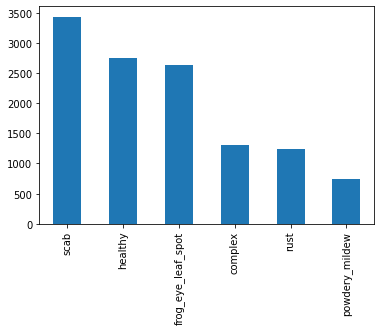

In [21]:
train['labels'].value_counts().plot(kind='bar')

In [22]:
len(train)

12112

In [23]:
test

,image,labels
3733,85dab161cf9895a5.jpg,complex
1411,bd8ed6d4fa680161.jpg,complex
3508,84936b111763f6ab.jpg,powdery_mildew
10021,b5e08197d9d6859a.jpg,frog_eye_leaf_spot
6350,9e0ba1619bdf4943.jpg,powdery_mildew
...,...,...
19485,fc8b609593385e33.jpg,frog_eye_leaf_spot
2996,80a2c93fd2d9655d.jpg,healthy
10569,bad992af47e26054.jpg,healthy
3674,859d3ac6e0bc4fa1.jpg,healthy


In [24]:
eval

,image,labels
14415,d64763342d8b568d.jpg,scab
12484,c797d09a486925be.jpg,healthy
10512,ba84d297977c0359.jpg,frog_eye_leaf_spot
14927,da979553d822352e.jpg,scab
3582,850367cf187768d6.jpg,rust
...,...,...
3168,81b74d197aec78d0.jpg,frog_eye_leaf_spot
7806,a8be209f5a8f3f01.jpg,scab
10735,bcbdca83444f309e.jpg,rust
14695,d8b533ee152daa60.jpg,frog_eye_leaf_spot


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [26]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [27]:
if torch.cuda.is_available():
  device=torch.device('cuda')

trans_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_eval=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/train', 
                                    transform=trans_train,
                                   )
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True,)

test_data = datasets.ImageFolder(root='/content/test', 
                                    transform=trans_test
                                   )
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=True,drop_last=True)

eval_data = datasets.ImageFolder(root='/content/eval', 
                                    transform=trans_eval
                                   )
eval_loader=DataLoader(dataset=eval_data,batch_size=32,shuffle=True,drop_last=True)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
real_batch=next(iter(train_loader))

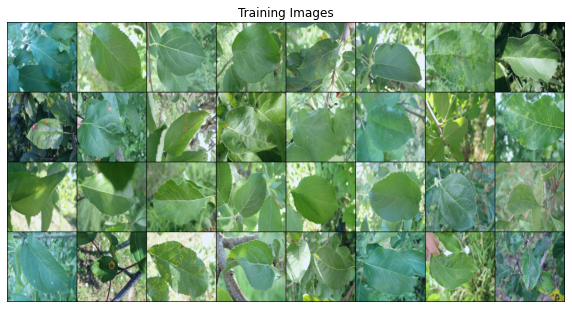

In [29]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],padding=2,normalize=True).cpu(),(1,2,0)));

In [30]:

num_class=6
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
  
        self.layer4 = self._make_layer(32, 2, stride = 2)#28*28
        self.layer5 = self._make_layer(16, 2, stride = 2)
        self.linear = nn.Linear(3136, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # out = self.layer4(out)

        # out = self.layer5(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [104]:
R=ResNet().to(device)

In [98]:
if os.path.exists('/content/drive/MyDrive/Plant_Pathology.pth'):
  print('s')
  R.load_state_dict(torch.load('/content/drive/MyDrive/Plant_Pathology.pth'))

s


In [105]:
criterion=nn.CrossEntropyLoss()

In [106]:
import torch.optim as optim
optim=optim.Adam(R.parameters(),lr=0.00001)

In [109]:
def train(R,optim,cri):
 
  for epoch in range(3):
    for index,sample in enumerate(train_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      optim.zero_grad()
      cost.backward()
      optim.step()
      if index%10==0:
        print('epoch {} , cost: {:.4f}'.format(epoch,cost.item()))
        test(R,cri)
        R.train()
      torch.save(R.state_dict(),'/content/drive/MyDrive/Plant_Pathology_lr_changed.pth')

In [110]:
def test(R,cri):
  R.eval()
  correct=0
  loss_avg=0
  with torch.no_grad():
    for index,sample in enumerate(test_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      loss_avg+=cost.item()
      prediction=out.max(1,keepdim=True)[1]
      correct+=prediction.eq(Y.view_as(prediction)).sum().item()
      


  test_accuracy=100*correct/len(test_loader.dataset)
  loss_avg/=len(test_loader.dataset)
  print('cost: {:.2f}%'.format(test_accuracy))
  print('loss_avg:',loss_avg)

In [ ]:
train(R,optim,criterion)

epoch 0 , cost: 2.5117
cost: 20.75%
loss_avg: 0.07135861969309144
epoch 0 , cost: 1.9121
cost: 25.76%
loss_avg: 0.06600811971700654
epoch 0 , cost: 1.6135
cost: 25.41%
loss_avg: 0.05990542162557361
epoch 0 , cost: 1.4911
cost: 25.90%
loss_avg: 0.0552793415065905
epoch 0 , cost: 1.6741
cost: 32.07%
loss_avg: 0.050803539610552194
epoch 0 , cost: 1.4747
cost: 33.33%
loss_avg: 0.04868605761629079
epoch 0 , cost: 1.3841


In [ ]:
ㄲㄲㄲ.

In [ ]:
/content/drive/MyDrive/Plant_Pathology.pth